# Project_Break_II_ML

# Flights Delay Prediction

### Introduction

Changes in schedules and delays in commercial flights are problems that affect everyone involved in aviation. From the passengers' perspective, it results in dissatisfied customers due to potential disruptions to their plans and the stress caused. The crew and other airport employees are also impacted, diverting manpower to resolve issues that could be minimized with better planning. The airlines, in the end, are among the most affected, facing dissatisfaction from both customers and employees, as well as significant financial losses due to airport fees, fines, passenger/crew rebooking, etc.

Thus, it is clear that the sooner a possible delay is predicted, the lower the damage will be for all involved. However, this is not easy, as flight delays are multi-variable and depend on unpredictable, stochastic, and uncontrollable factors, such as extreme weather events, technical problems with aircraft, security-related issues, etc. Nevertheless, although it is not possible to predict all the sources of delays, it is possible to identify some patterns that fall under the logistical control of airports and airlines. Therefore, the following work aims to use logistical data, geolocation, and weather forecasting data to identify patterns and create a classifier that can predict whether a flight will be delayed or not (binary classifier), using only information that can be obtained well in advance, enabling decision-making by airport and airline organizations.

<img src="src/img/openart_image_1_1.jpg" width="1200"/>


This work aims to use a dataset on flights, geolocation, and meteorological indicators to predict possible delays. The dataset used was obtained from the following Kaggle page: https://www.kaggle.com/datasets/bordanova/2023-us-civil-flights-delay-meteo-and-aircraft/data

## General Objective:
- Prediction of whether a flight will be delayed at takeoff;

## Specific Objective:
- A binary classifier to classify delayed flights (class 1) and on-time flights (class 0) within a 15-minute tolerance beyond the scheduled time. For this objective, only logistical data available since the flight booking and weather forecasts will be used, without real-time updates immediately before takeoff. This makes the classifier very challenging but provides a highly important predictive potential, as it helps identify delay patterns that are independent of unpredictable, stochastic, and uncontrollable events;

https://www.kaggle.com/datasets/bordanova/2023-us-civil-flights-delay-meteo-and-aircraft/data

-------------------------------

# *Departure Delay Classification*

Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
pd.set_option('display.max_columns', None)

Importing Personalized Tools

In [3]:
import sys
import os

sys.path.append(os.path.abspath('src'))

from utils.User_Functions import *

In [4]:
try_GPU()

Using GPU


Importing Datasets

In [5]:
df_flights = pd.read_csv("./src/data/US_flights_2023.csv")
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6743404 entries, 0 to 6743403
Data columns (total 24 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   FlightDate          object
 1   Day_Of_Week         int64 
 2   Airline             object
 3   Tail_Number         object
 4   Dep_Airport         object
 5   Dep_CityName        object
 6   DepTime_label       object
 7   Dep_Delay           int64 
 8   Dep_Delay_Tag       int64 
 9   Dep_Delay_Type      object
 10  Arr_Airport         object
 11  Arr_CityName        object
 12  Arr_Delay           int64 
 13  Arr_Delay_Type      object
 14  Flight_Duration     int64 
 15  Distance_type       object
 16  Delay_Carrier       int64 
 17  Delay_Weather       int64 
 18  Delay_NAS           int64 
 19  Delay_Security      int64 
 20  Delay_LastAircraft  int64 
 21  Manufacturer        object
 22  Model               object
 23  Aicraft_age         int64 
dtypes: int64(11), object(13)
memory usage: 1.2+ GB


In [6]:
df_weather = pd.read_csv("./src/data/weather_meteo_by_airport.csv")
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132860 entries, 0 to 132859
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time        132860 non-null  object 
 1   tavg        132860 non-null  float64
 2   tmin        132860 non-null  float64
 3   tmax        132860 non-null  float64
 4   prcp        132860 non-null  float64
 5   snow        132860 non-null  float64
 6   wdir        132860 non-null  float64
 7   wspd        132860 non-null  float64
 8   pres        132860 non-null  float64
 9   airport_id  132860 non-null  object 
dtypes: float64(8), object(2)
memory usage: 10.1+ MB


In [7]:
df_location = pd.read_csv("./src/data/airports_geolocation.csv")
df_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  364 non-null    object 
 1   AIRPORT    364 non-null    object 
 2   CITY       364 non-null    object 
 3   STATE      364 non-null    object 
 4   COUNTRY    364 non-null    object 
 5   LATITUDE   364 non-null    float64
 6   LONGITUDE  364 non-null    float64
dtypes: float64(2), object(5)
memory usage: 20.0+ KB


Merging Datasets

In [8]:
# Converting FlightDate and time to datetime
df_flights['FlightDate'] = pd.to_datetime(df_flights['FlightDate'], errors='coerce')
df_weather['time'] = pd.to_datetime(df_weather['time'], errors='coerce')

# Merging DataFrames df_flights, df_location, df_weather
merged_df = pd.merge(df_flights, df_location,
                    how='left',
                    left_on=['Dep_Airport'],
                    right_on=['IATA_CODE'])

merged_df = pd.merge(merged_df, df_weather,
                      how='left',
                      left_on=['Dep_Airport', 'FlightDate'],
                      right_on=['airport_id', 'time'])


In [9]:
merged_df.sample(3)

,FlightDate,Day_Of_Week,Airline,Tail_Number,Dep_Airport,Dep_CityName,DepTime_label,Dep_Delay,Dep_Delay_Tag,Dep_Delay_Type,Arr_Airport,Arr_CityName,Arr_Delay,Arr_Delay_Type,Flight_Duration,Distance_type,Delay_Carrier,Delay_Weather,Delay_NAS,Delay_Security,Delay_LastAircraft,Manufacturer,Model,Aicraft_age,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,airport_id
1597815,2023-04-16,7,United Air Lines Inc.,N73256,DEN,"Denver, CO",Morning,94,1,Hight >60min,BIL,"Billings, MT",83,Hight >60min,80,Short Haul >1500Mi,29,0,0,0,54,BOEING,737 NG,24,DEN,Denver International Airport,Denver,CO,USA,39.85841,-104.66700,2023-04-16,4.1,-4.9,16.7,0.0,0.0,123.0,14.8,1021.2,DEN
1857907,2023-04-17,1,Frontier Airlines Inc.,N715FR,MCO,"Orlando, FL",Afternoon,19,1,Medium >15min,BDL,"Hartford, CT",0,Low <5min,150,Short Haul >1500Mi,0,0,0,0,0,AIRBUS,A321,8,MCO,Orlando International Airport,Orlando,FL,USA,28.42889,-81.31603,2023-04-17,21.3,17.2,24.4,15.7,0.0,11.0,8.4,1013.6,MCO
4716936,2023-09-06,3,American Eagle Airlines Inc.,N241NN,MEM,"Memphis, TN",Afternoon,-6,0,Low <5min,DFW,"Dallas/Fort Worth, TX",-16,Low <5min,96,Short Haul >1500Mi,0,0,0,0,0,EMBRAER,170/175,8,MEM,Memphis International Airport,Memphis,TN,USA,35.04242,-89.97667,2023-09-06,26.5,22.2,33.3,24.6,0.0,191.0,12.2,1013.5,MEM


| Field               | Description                                               | Example                               |
|---------------------|-----------------------------------------------------------|---------------------------------------|
| FlightDate         | The date of the flight.                                    | 2024-09-09                           |
| Day_Of_Week        | The day of the week when the flight occurred.              | Monday                               |
| Airline           | The name or code of the airline operating the flight.      | AA for American Airlines             |
| Tail_Number       | The unique identifier (registration number) of the aircraft. | N123AA                               |
| Dep_Airport       | The IATA code of the departure airport.                    | JFK                                  |
| Dep_CityName      | The name of the city where the departure airport is located. | New York                             |
| DepTime_label     | The categorized or labeled departure time.                 | Morning                              |
| Dep_Delay        | The number of minutes the flight was delayed at departure.  | 1                                   |
| Dep_Delay_Tag    | Categorical representation of the departure delay.          | On-time                              |
| Dep_Delay_Type   | The type or reason for the departure delay.                 | Operational                          |
| Arr_Airport      | The IATA code of the arrival airport.                       | LAX                                  |
| Arr_CityName     | The name of the city where the arrival airport is located.  | Los Angeles                          |
| Arr_Delay       | The number of minutes the flight was delayed at arrival.     | 10                                   |
| Arr_Delay_Type  | The type or reason for the arrival delay.                    | Weather                              |
| Flight_Duration | The duration of the flight.                                  | 300 minutes                          |
| Distance_type   | The classification of flight distance.                       | Long-haul                            |
| Delay_Carrier   | The number of minutes the delay is attributed to the airline/carrier. | 5                          |
| Delay_Weather   | The number of minutes the delay is attributed to weather conditions. | 10                         |
| Delay_NAS       | The number of minutes the delay is attributed to National Airspace System issues. | 0 |
| Delay_Security  | The number of minutes the delay is attributed to security-related issues. | 0 |
| Delay_LastAircraft | The number of minutes the delay is attributed to delays in the aircraft's previous flight. | 20 |
| Manufacturer    | The company that manufactured the aircraft.                   | Boeing                               |
| Model          | The model of the aircraft.                                     | Boeing 737                           |
| Aircraft_age   | The age of the aircraft in years.                             | 12 years                             |
| time           | The specific time or timestamp associated with the flight record. | 12:30 PM                         |
| tavg           | The average temperature on the day of the flight.             | 22°C                                 |
| tmin           | The minimum temperature on the day of the flight.             | 18°C                                 |
| tmax           | The maximum temperature on the day of the flight.             | 28°C                                 |
| prcp           | The amount of precipitation on the day of the flight.         | 2 mm                                 |
| snow           | The amount of snowfall on the day of the flight.              | 0 mm                                 |
| wdir           | The wind direction.                                           | 270°                                 |
| wspd           | The wind speed.                                               | 15 km/h                              |
| pres           | The atmospheric pressure.                                     | 1015 hPa                             |
| airport_id     | A unique identifier for the airport.                          | 12345                                |
| IATA_CODE      | The International Air Transport Association code for the airport. | JFK                            |
| AIRPORT        | The name of the airport.                                      | John F. Kennedy International Airport |
| CITY           | The city where the airport is located.                        | New York                             |
| STATE          | The state or region where the airport is located.             | NY                                   |
| COUNTRY        | The country where the airport is located.                     | USA                                  |
| LATITUDE       | The latitude coordinate of the airport.                       | 40.6413° N                           |
| LONGITUDE      | The longitude coordinate of the airport.                      | 73.7781° W                           |


In [10]:
# Dropping redundant and unnecessary columns
merged_df.drop(columns=["IATA_CODE", "AIRPORT", "CITY", "STATE", "COUNTRY", "time", "airport_id"], inplace=True)

In [11]:
# Splitting FlightDate into Day and Month columns
merged_df['Month'] = merged_df['FlightDate'].dt.month
merged_df['Day'] = merged_df['FlightDate'].dt.day
merged_df.drop(columns=["FlightDate"], inplace=True)
merged_df.sample(2)


,Day_Of_Week,Airline,Tail_Number,Dep_Airport,Dep_CityName,DepTime_label,Dep_Delay,Dep_Delay_Tag,Dep_Delay_Type,Arr_Airport,Arr_CityName,Arr_Delay,Arr_Delay_Type,Flight_Duration,Distance_type,Delay_Carrier,Delay_Weather,Delay_NAS,Delay_Security,Delay_LastAircraft,Manufacturer,Model,Aicraft_age,LATITUDE,LONGITUDE,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,Month,Day
1818147,2,Delta Air Lines Inc,N925AT,ATL,"Atlanta, GA",Morning,-4,0,Low <5min,MYR,"Myrtle Beach, SC",-4,Low <5min,70,Short Haul >1500Mi,0,0,0,0,0,BOEING,717,24,33.64044,-84.42694,12.6,2.2,22.8,0.0,0.0,35.0,5.0,1026.4,4,11
5890613,4,Spirit Air Lines,N605NK,SJU,"San Juan, PR",Afternoon,-3,0,Low <5min,ATL,"Atlanta, GA",-7,Low <5min,234,Medium Haul <3000Mi,0,0,0,0,0,AIRBUS,A320,14,18.43942,-66.00183,27.0,24.4,30.0,2.5,0.0,81.0,13.6,1016.2,11,30


#### Analysing merged_df data

The function ```type_variables``` below analyzes the nature of the data in each column and classifies them as numerical, categorical, and "ID-like" features, which are categorical features represented as numbers.

In [12]:
features_num, features_cat, features_id = type_features(merged_df)

print("Numerical features:", features_num)
print("Categorical features:", features_cat)
print("ID features (numeric categoricals):", features_id)

Numerical features: ['Day_Of_Week', 'Dep_Delay', 'Dep_Delay_Tag', 'Arr_Delay', 'Flight_Duration', 'Delay_Carrier', 'Delay_Weather', 'Delay_NAS', 'Delay_Security', 'Delay_LastAircraft', 'Aicraft_age', 'LATITUDE', 'LONGITUDE', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'pres', 'Month', 'Day']
Categorical features: ['Airline', 'Tail_Number', 'Dep_Airport', 'Dep_CityName', 'DepTime_label', 'Dep_Delay_Type', 'Arr_Airport', 'Arr_CityName', 'Arr_Delay_Type', 'Distance_type', 'Manufacturer', 'Model']
ID features (numeric categoricals): []


Select only logistical variables available in advance + weather forecasts.

In [13]:
features_num = ['Delay_LastAircraft', 'Day_Of_Week', 'Flight_Duration', 'Aicraft_age', 
                'LATITUDE', 'LONGITUDE', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'pres', 'Month', 'Day']

features_cat = ["Airline", "Tail_Number", "Dep_Airport", "DepTime_label", "Arr_Airport", "Distance_type", 
                "Manufacturer", "Model"]

features_id = []

categorical_features = features_cat


| Field            | Description                                           | Example                               |
|------------------|-------------------------------------------------------|---------------------------------------|
|Delay_LastAircraft|  The number of minutes the delay is attributed to delays in the aircraft's previous flight. | 30 |
| Day_Of_Week     | The day of the week when the flight occurred.         |     3                              |
| Day              | The day of the month when the flight occurred.       |                28                 |
| Month          |      The month when the flight occurred.               |           11                        |
| Flight_Duration | The duration of the flight.                           | 300 minutes                          |
| Aircraft_age    | The age of the aircraft in years.                     | 12 years                             |
| Airline         | The name or code of the airline operating the flight. | AA for American Airlines             |
| Tail_Number     | The unique identifier of the aircraft.                | N123AA                               |
| Dep_Airport     | The IATA code of the departure airport.               | JFK                                  |
| DepTime_label   | The categorized or labeled departure time.            | Morning                              |
| Arr_Airport     | The IATA code of the arrival airport.                 | LAX                                  |
| Distance_type   | The classification of flight distance.                | Long-haul                            |
| Manufacturer    | The company that manufactured the aircraft.           | Boeing                               |
| Model          | The model of the aircraft.                             | Boeing 737                           |
| LATITUDE        | The latitude coordinate of the airport.               | 40.6413° N                           |
| LONGITUDE       | The longitude coordinate of the airport.              | 73.7781° W                           |
| tavg            | The average temperature on the day of the flight.     | 22°C                                 |
| tmin            | The minimum temperature on the day of the flight.     | 18°C                                 |
| tmax            | The maximum temperature on the day of the flight.     | 28°C                                 |
| prcp            | The amount of precipitation on the day of the flight. | 2 mm                                 |
| snow            | The amount of snowfall on the day of the flight.      | 0 mm                                 |
| wdir            | The wind direction.                                   | 270°                                 |
| wspd            | The wind speed.                                       | 15 km/h                              |
| pres            | The atmospheric pressure.                             | 1015 hPa                             |



Declaring target for binary classification of departure delay

In [14]:
target_class = "Dep_Delay_Tag"

In [15]:
# Counting nulls
df = merged_df[features_num + features_cat + [target_class]].copy()
df.isnull().sum()

Delay_LastAircraft    0
Day_Of_Week           0
Flight_Duration       0
Aicraft_age           0
LATITUDE              0
LONGITUDE             0
tavg                  0
tmin                  0
tmax                  0
prcp                  0
snow                  0
wdir                  0
wspd                  0
pres                  0
Month                 0
Day                   0
Airline               0
Tail_Number           0
Dep_Airport           0
DepTime_label         0
Arr_Airport           0
Distance_type         0
Manufacturer          0
Model                 0
Dep_Delay_Tag         0
dtype: int64

In [16]:
print("Number of duplicates in df:", df.duplicated().sum())
df.loc[df.duplicated()].sample()

Number of duplicates in df: 762


,Delay_LastAircraft,Day_Of_Week,Flight_Duration,Aicraft_age,LATITUDE,LONGITUDE,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,Month,Day,Airline,Tail_Number,Dep_Airport,DepTime_label,Arr_Airport,Distance_type,Manufacturer,Model,Dep_Delay_Tag
3059036,0,3,91,5,46.26468,-119.11903,17.7,7.8,26.1,0.0,0.0,42.0,7.3,1020.5,6,21,Skywest Airlines Inc.,N294SY,PSC,Afternoon,SLC,Short Haul >1500Mi,EMBRAER,170/175,0


In [17]:
df.drop_duplicates(inplace=True, keep='first')

In [18]:
# Looking for the target proportion
df[target_class].value_counts(normalize=True)

Dep_Delay_Tag
0    0.620973
1    0.379027
Name: proportion, dtype: float64

Randomly reducing the dataset to 10% size for computational performance during the following modeling processes

In [19]:
from sklearn.utils import resample

# Random subsampling
data_sample = resample(df, replace=False, n_samples=int(len(df) * 0.1), random_state=42)

print("Original Dataset size:", len(df))
print("Dataset size after subsampling:", len(data_sample))

Original Dataset size: 6742642
Dataset size after subsampling: 674264


Dividing train and test set

In [20]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data_sample, test_size=0.2, random_state=42)
print(train_set.shape)
print(test_set.shape)

(539411, 25)
(134853, 25)


### Detecting Outliers

The Isolation Forest is an unsupervised machine learning algorithm used for detecting outliers in large datasets. It works by isolating observations through random partitioning of features, which makes it effective in handling high-dimensional data. The algorithm identifies outliers as those points that are isolated quicker than normal observations. Due to its efficiency, it is particularly useful for large datasets where traditional methods like distance-based and clustering techniques may be computationally expensive.


In [21]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(train_set[features_num])  # Only on original numerical features

train_set_clean = train_set[outliers == 1].copy()  # Remove detected outliers

# Now you can transform the numerical features of train_set_clean

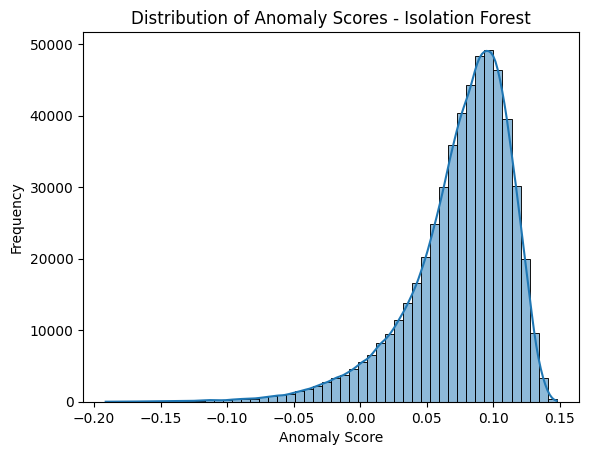

In [22]:
# Get anomaly scores
anomaly_scores = iso_forest.decision_function(train_set[features_num])

# Plot anomaly score distribution
sns.histplot(anomaly_scores, bins=50, kde=True)
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Distribution of Anomaly Scores - Isolation Forest")
plt.show()


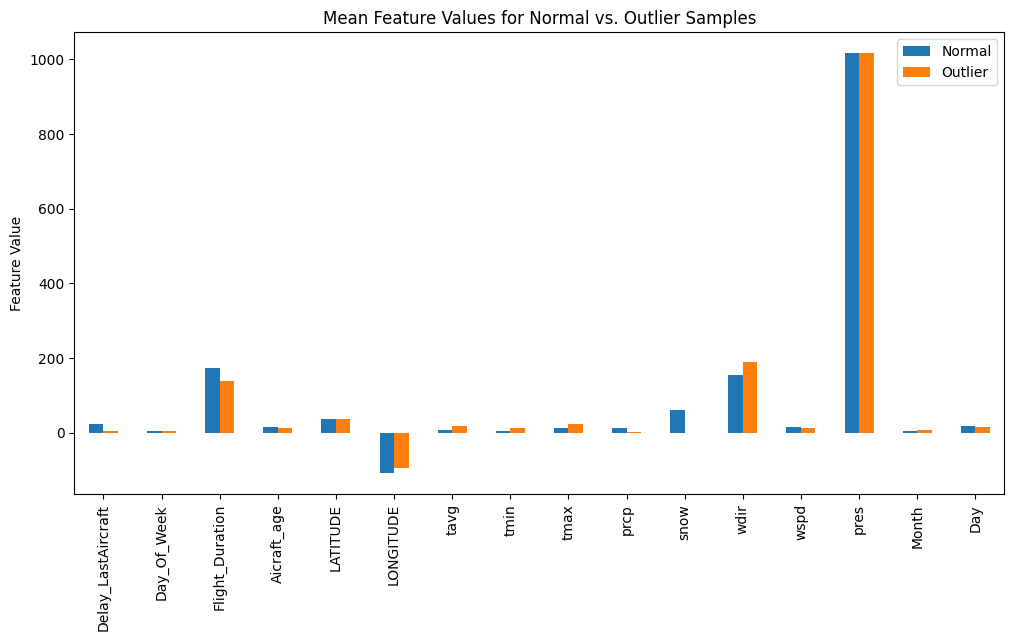

In [23]:
# Add outlier labels (1 = normal, -1 = outlier)
train_set["outlier"] = outliers

# Compute mean feature values for normal vs. outlier samples
feature_impact = train_set.groupby("outlier")[features_num].mean().T
feature_impact.columns = ["Normal", "Outlier"]

# Plot feature differences
feature_impact.plot(kind="bar", figsize=(12,6))
plt.title("Mean Feature Values for Normal vs. Outlier Samples")
plt.ylabel("Feature Value")
plt.show()


In [24]:
print("Nmber of identified outliers:", len(train_set) - len(train_set_clean), "out of", len(train_set_clean))
print("Percentage of outliers:", round(((len(train_set) - len(train_set_clean)) * 100) / len(train_set), 4), "%")


Nmber of identified outliers: 26971 out of 512440
Percentage of outliers: 5.0001 %


In [25]:
print("Target proportion in train_set:\n", train_set[target_class].value_counts(normalize=True))
print("\nTarget proportion in train_set_clean:\n", train_set_clean[target_class].value_counts(normalize=True))

Target proportion in train_set:
 Dep_Delay_Tag
0    0.620621
1    0.379379
Name: proportion, dtype: float64

Target proportion in train_set_clean:
 Dep_Delay_Tag
0    0.627371
1    0.372629
Name: proportion, dtype: float64


The removal of outliers does not significantly alter the target proportion, which is a great indicator in this specific problem, showing that the identified and removed outliers are equally distributed between the two classes.

In [26]:
#Applying outliers prediction and removal to test_set
outliers_test = iso_forest.predict(test_set[features_num])

test_set_clean = test_set[outliers_test == 1].copy()  # Remove detected outliers from test_set

print("Percentage of outliers in test set:", round((len(test_set) - len(test_set_clean)) * 100 / len(test_set),4), "%")


Percentage of outliers in test set: 5.0618 %


### Target Encoding with K-Fold

The **`target_encoding_kfold`** function applies **Target Encoding** with **K-Fold Cross Validation** to prevent **data leakage** during training, ensuring the model only learns from training data.



#### Key Steps:

1. **K-Fold Validation**:
   - Splits the training data into **n_splits** (default 5) using **StratifiedKFold** to ensure balanced target distribution.
   - Prevents **data leakage** by ensuring encoding is only based on training data.

2. **Resetting Indices**:
   - Resets indices in both train and validation sets to avoid **index misalignment** when applying target encoding.

3. **Smoothing**:
   - Calculates the category mean with a smoothing technique that combines the category mean with the global mean to handle sparse categories.

4. **Mapping and Handling Unseen Categories**:
   - Categories in validation and test sets are **mapped** to the calculated target mean; missing categories are assigned the **global mean** to avoid errors.



#### Why K-Fold?

- **K-Fold** ensures that encoding is done only with training data, preventing future data from contaminating the model and causing **data leakage**.



This approach guarantees **robust target encoding**, preserves model integrity, and prevents **overfitting**.


The following cell counts how many categorical values exist in the test set but not in the train set. High values may indicate issues for target encoding strategy, as unseen values in the test set will be assigned the global mean.

In [27]:
# Check non correspondenting values in test set/train set
non_correspondence = {col: {'unique': [], 'absolute': [], 'total_percentage': []} for col in categorical_features}

# Iterate over the categorical columns
for col in categorical_features:
    # Identify unique values in test_set that are not in train_set
    test_values = set(test_set[col])
    train_values = set(train_set_clean[col])
    
    # Values in test_set but not in train_set
    non_matching_values = test_values - train_values
    
    # Count the number of unique values and the absolute count of these values
    non_correspondence[col]['unique'] = len(non_matching_values)
    non_correspondence[col]['absolute'] = sum(test_set[col].isin(non_matching_values))
    non_correspondence[col]['total_percentage'] = (len(non_matching_values) * 100) / len(test_set)
    
# Convert the dictionary to a DataFrame
non_correspondence_df = pd.DataFrame(non_correspondence)
non_correspondence_df



,Airline,Tail_Number,Dep_Airport,DepTime_label,Arr_Airport,Distance_type,Manufacturer,Model
unique,0.0,9.000000,1.000000,0.0,1.000000,0.0,0.0,0.0
absolute,0.0,10.000000,4.000000,0.0,1.000000,0.0,0.0,0.0
total_percentage,0.0,0.006674,0.000742,0.0,0.000742,0.0,0.0,0.0


In [28]:
train_encoded, test_encoded, encoded_columns = target_encoding_kfold(train_set_clean, test_set_clean, categorical_features, target_class, n_splits=5, smoothing=0.3, seed=42)

print("Encoded columns by target_encoding_kfold:", encoded_columns)


Encoded columns by target_encoding_kfold: ['Airline_te', 'Tail_Number_te', 'Dep_Airport_te', 'DepTime_label_te', 'Arr_Airport_te', 'Distance_type_te', 'Manufacturer_te', 'Model_te']


##### Numerical Transformations

In [29]:
# Continuous features
features_hist = ['Delay_LastAircraft','Flight_Duration', 'Aicraft_age', 
                'LATITUDE', 'LONGITUDE', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'pres']

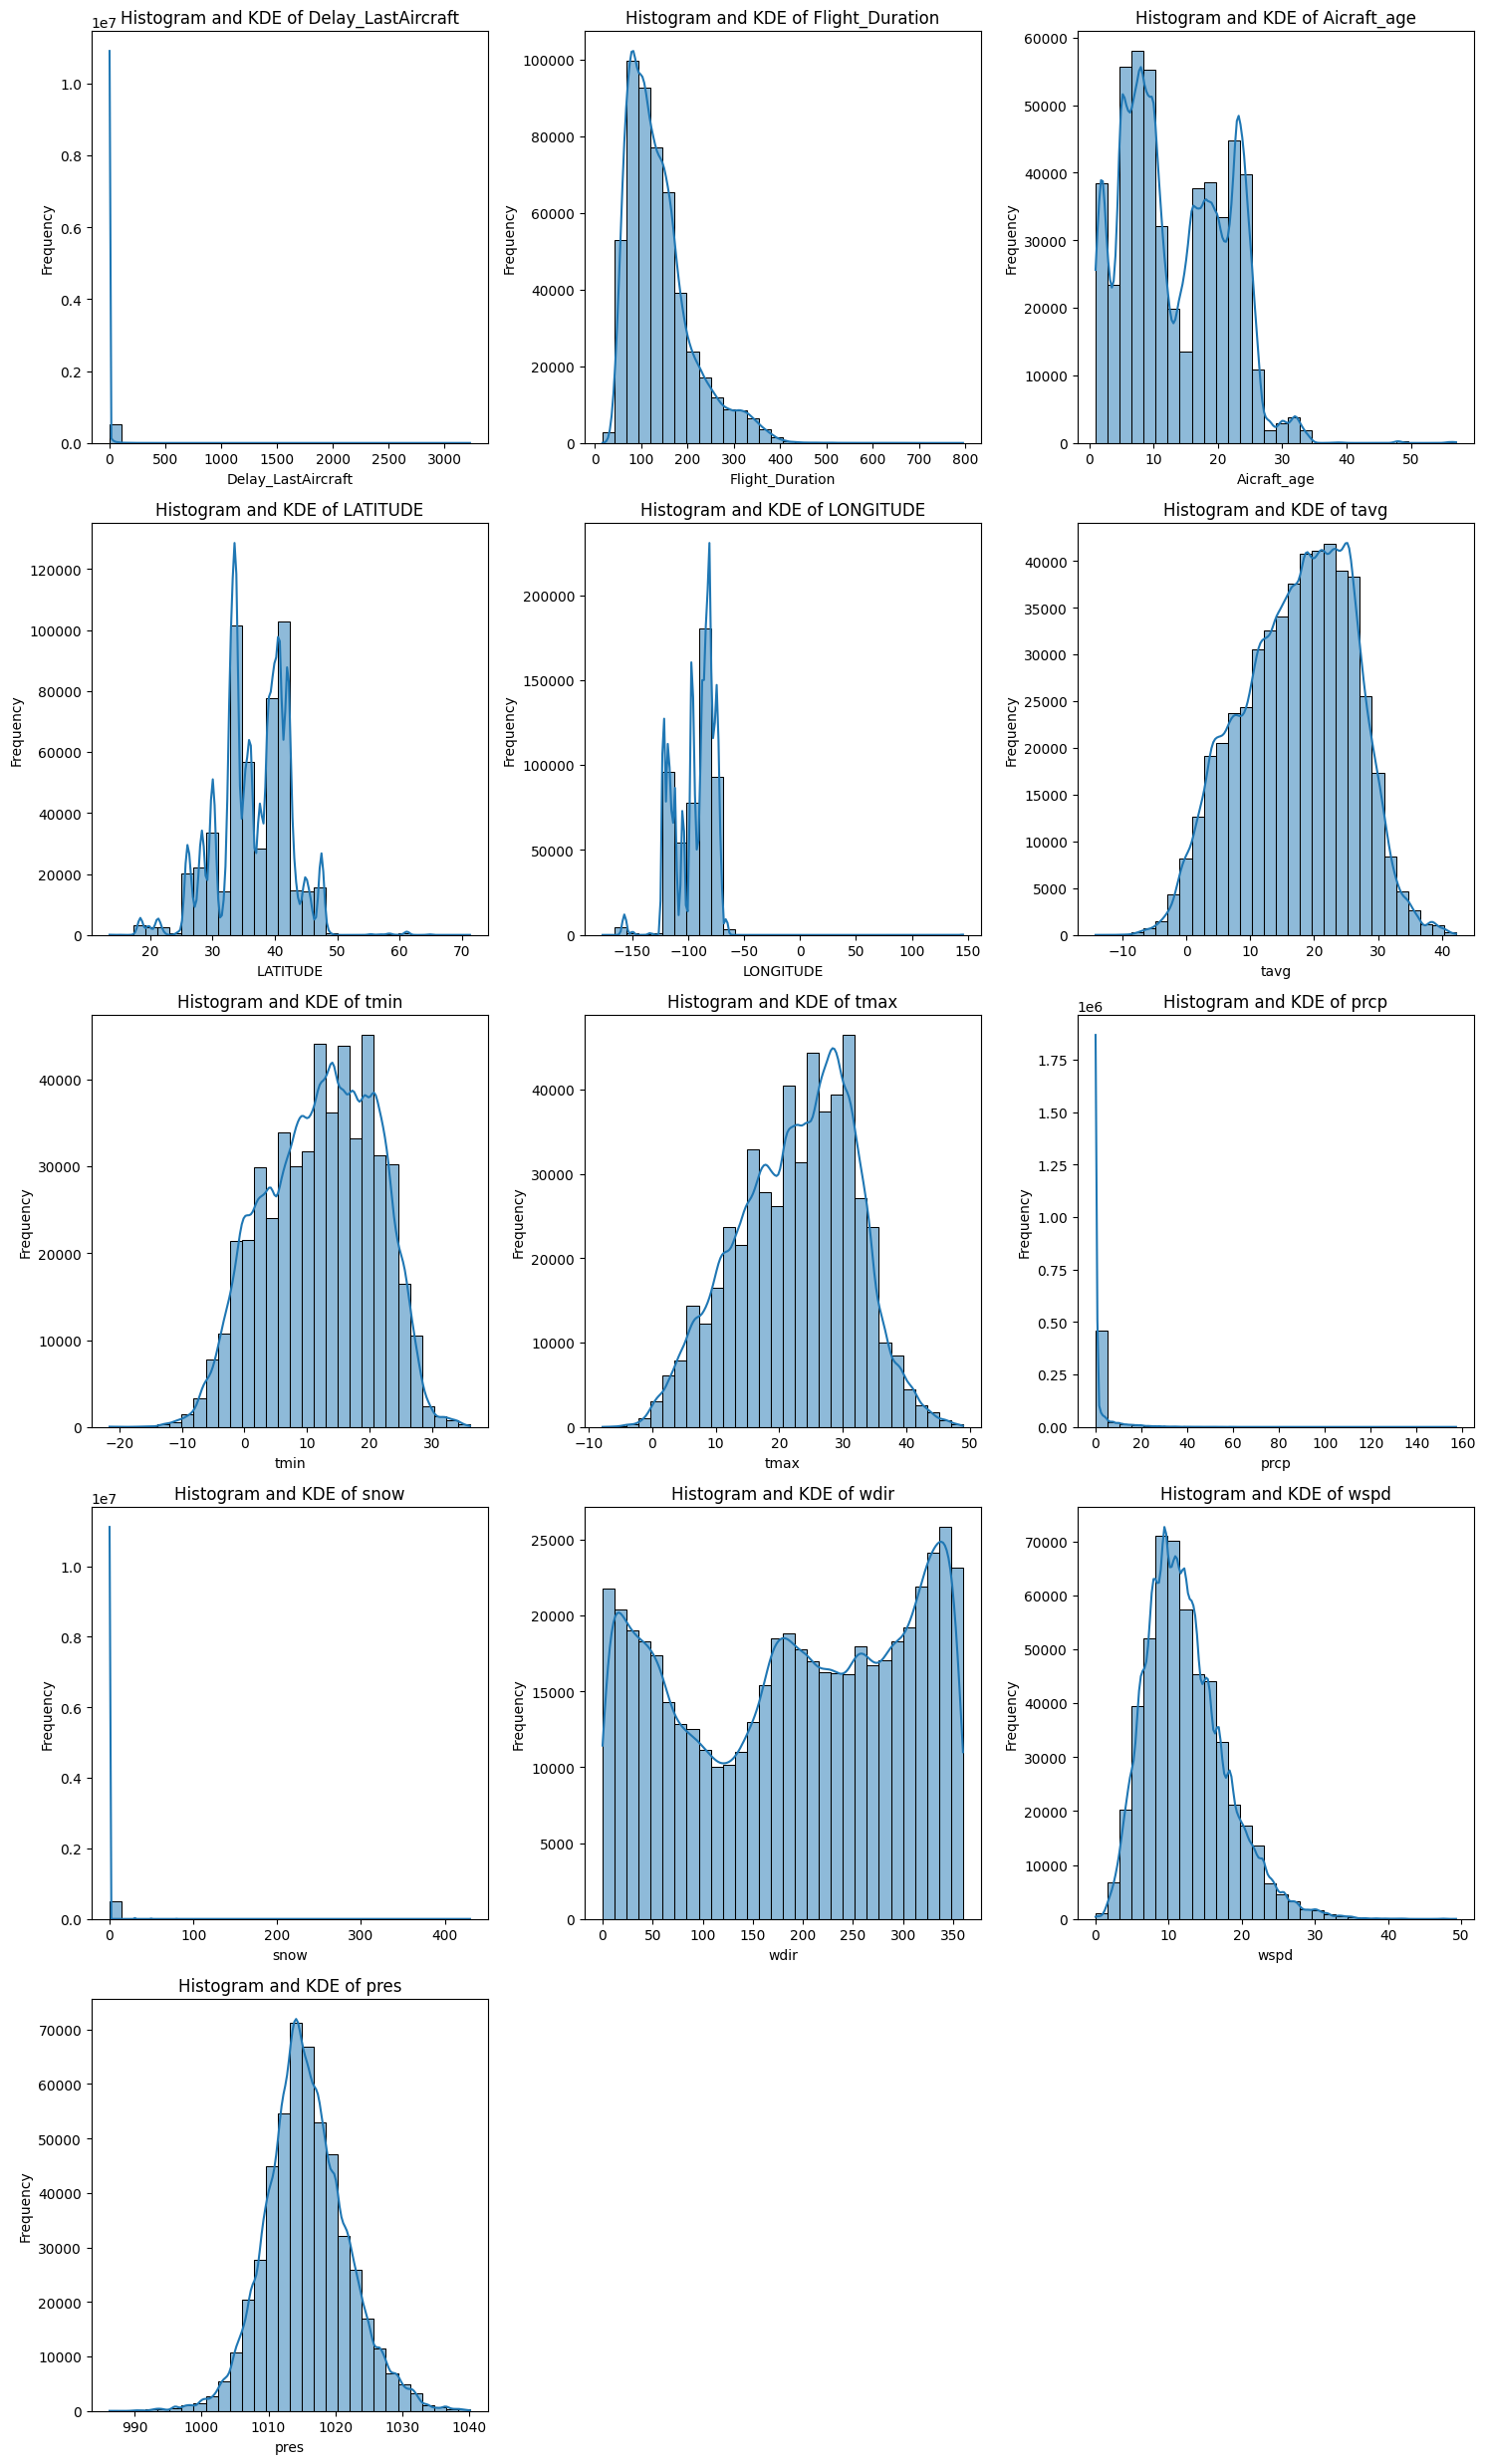

In [30]:
# Call the function
plot_histograms(train_encoded, features_hist)

The function below, ```suggest_best_transformations```, analyzes the skewness of numeric features in a DataFrame and recommends transformations to reduce skewness if it exceeds a specified threshold. It evaluates the following transformations: square root, cube root, log1p, and Box-Cox. The transformation resulting in the lowest skewness (closest to 0) is suggested. If no transformation is necessary, it indicates that the skewness is within an acceptable range.

In [31]:
transformation_dict = suggest_best_transformations(train_encoded, features_hist, skew_threshold=0.5)

Suggested transformations:

Column 'Delay_LastAircraft': Original skew: 17.979
  sqrt -> new skew 4.370
  cbrt -> new skew 3.357
  log1p -> new skew 3.077
  Column 'Delay_LastAircraft': log1p transformation suggested (new skew: 3.077)

Column 'Flight_Duration': Original skew: 1.330
  sqrt -> new skew 0.709
  cbrt -> new skew 0.513
  log1p -> new skew 0.140
  boxcox -> new skew 0.008
  Column 'Flight_Duration': boxcox transformation suggested (new skew: 0.008)

Column 'Aicraft_age': Original skew: 0.305
  No transformation needed (below threshold)

Column 'LATITUDE': Original skew: -0.253
  No transformation needed (below threshold)

Column 'LONGITUDE': Original skew: -0.508
  cbrt -> new skew 3.866
  No transformation suggested (all skews worsened)

Column 'tavg': Original skew: -0.215
  No transformation needed (below threshold)

Column 'tmin': Original skew: -0.199
  No transformation needed (below threshold)

Column 'tmax': Original skew: -0.259
  No transformation needed (below thr

In [32]:
train_encoded.head()

,Delay_LastAircraft,Day_Of_Week,Flight_Duration,Aicraft_age,LATITUDE,LONGITUDE,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,Month,Day,Dep_Delay_Tag,Airline_te,Tail_Number_te,Dep_Airport_te,DepTime_label_te,Arr_Airport_te,Distance_type_te,Manufacturer_te,Model_te
6491569,0,7,78,20,38.69542,-121.59077,8.4,3.3,14.4,0.0,0.0,342.0,5.8,1023.0,12,24,1,0.513984,0.512462,0.370830,0.274988,0.334624,0.365439,0.424051,0.432789
1595477,0,1,288,29,33.94254,-118.40807,16.2,13.9,19.4,0.0,0.0,234.0,11.9,1011.8,4,24,1,0.367254,0.638977,0.363073,0.424054,0.331681,0.423955,0.424051,0.502470
4252364,0,5,360,1,40.69250,-74.16866,23.8,20.0,27.0,12.3,0.0,280.0,15.6,1008.1,8,18,0,0.366306,0.350168,0.396716,0.273527,0.368707,0.424035,0.424313,0.432692
3879591,0,3,155,11,35.04242,-89.97667,25.5,19.4,31.1,0.0,0.0,30.0,16.6,1011.4,8,30,0,0.219355,0.217795,0.312947,0.274781,0.305848,0.365081,0.240634,0.240634
2209919,0,4,81,13,36.12448,-86.67818,22.1,19.4,25.6,0.5,0.0,127.0,10.8,1017.7,5,11,1,0.370139,0.356232,0.398093,0.424054,0.313544,0.365439,0.424051,0.432789


In [33]:
train_encoded, test_encoded = apply_transformations(train_encoded, test_encoded, transformation_dict)

In [34]:
train_encoded.head()

,Delay_LastAircraft,Day_Of_Week,Flight_Duration,Aicraft_age,LATITUDE,LONGITUDE,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,Month,Day,Dep_Delay_Tag,Airline_te,Tail_Number_te,Dep_Airport_te,DepTime_label_te,Arr_Airport_te,Distance_type_te,Manufacturer_te,Model_te
6491569,0.0,7,3.412726,20,38.69542,-121.59077,8.4,3.3,14.4,0.000000,0.0,342.0,2.408319,1023.0,12,24,1,0.513984,0.512462,0.370830,0.274988,0.334624,0.365439,0.424051,0.432789
1595477,0.0,1,4.130174,29,33.94254,-118.40807,16.2,13.9,19.4,0.000000,0.0,234.0,3.449638,1011.8,4,24,1,0.367254,0.638977,0.363073,0.424054,0.331681,0.423955,0.424051,0.502470
4252364,0.0,5,4.242552,1,40.69250,-74.16866,23.8,20.0,27.0,2.308350,0.0,280.0,3.949684,1008.1,8,18,0,0.366306,0.350168,0.396716,0.273527,0.368707,0.424035,0.424313,0.432692
3879591,0.0,3,3.802796,11,35.04242,-89.97667,25.5,19.4,31.1,0.000000,0.0,30.0,4.074310,1011.4,8,30,0,0.219355,0.217795,0.312947,0.274781,0.305848,0.365081,0.240634,0.240634
2209919,0.0,4,3.434915,13,36.12448,-86.67818,22.1,19.4,25.6,0.793701,0.0,127.0,3.286335,1017.7,5,11,1,0.370139,0.356232,0.398093,0.424054,0.313544,0.365439,0.424051,0.432789


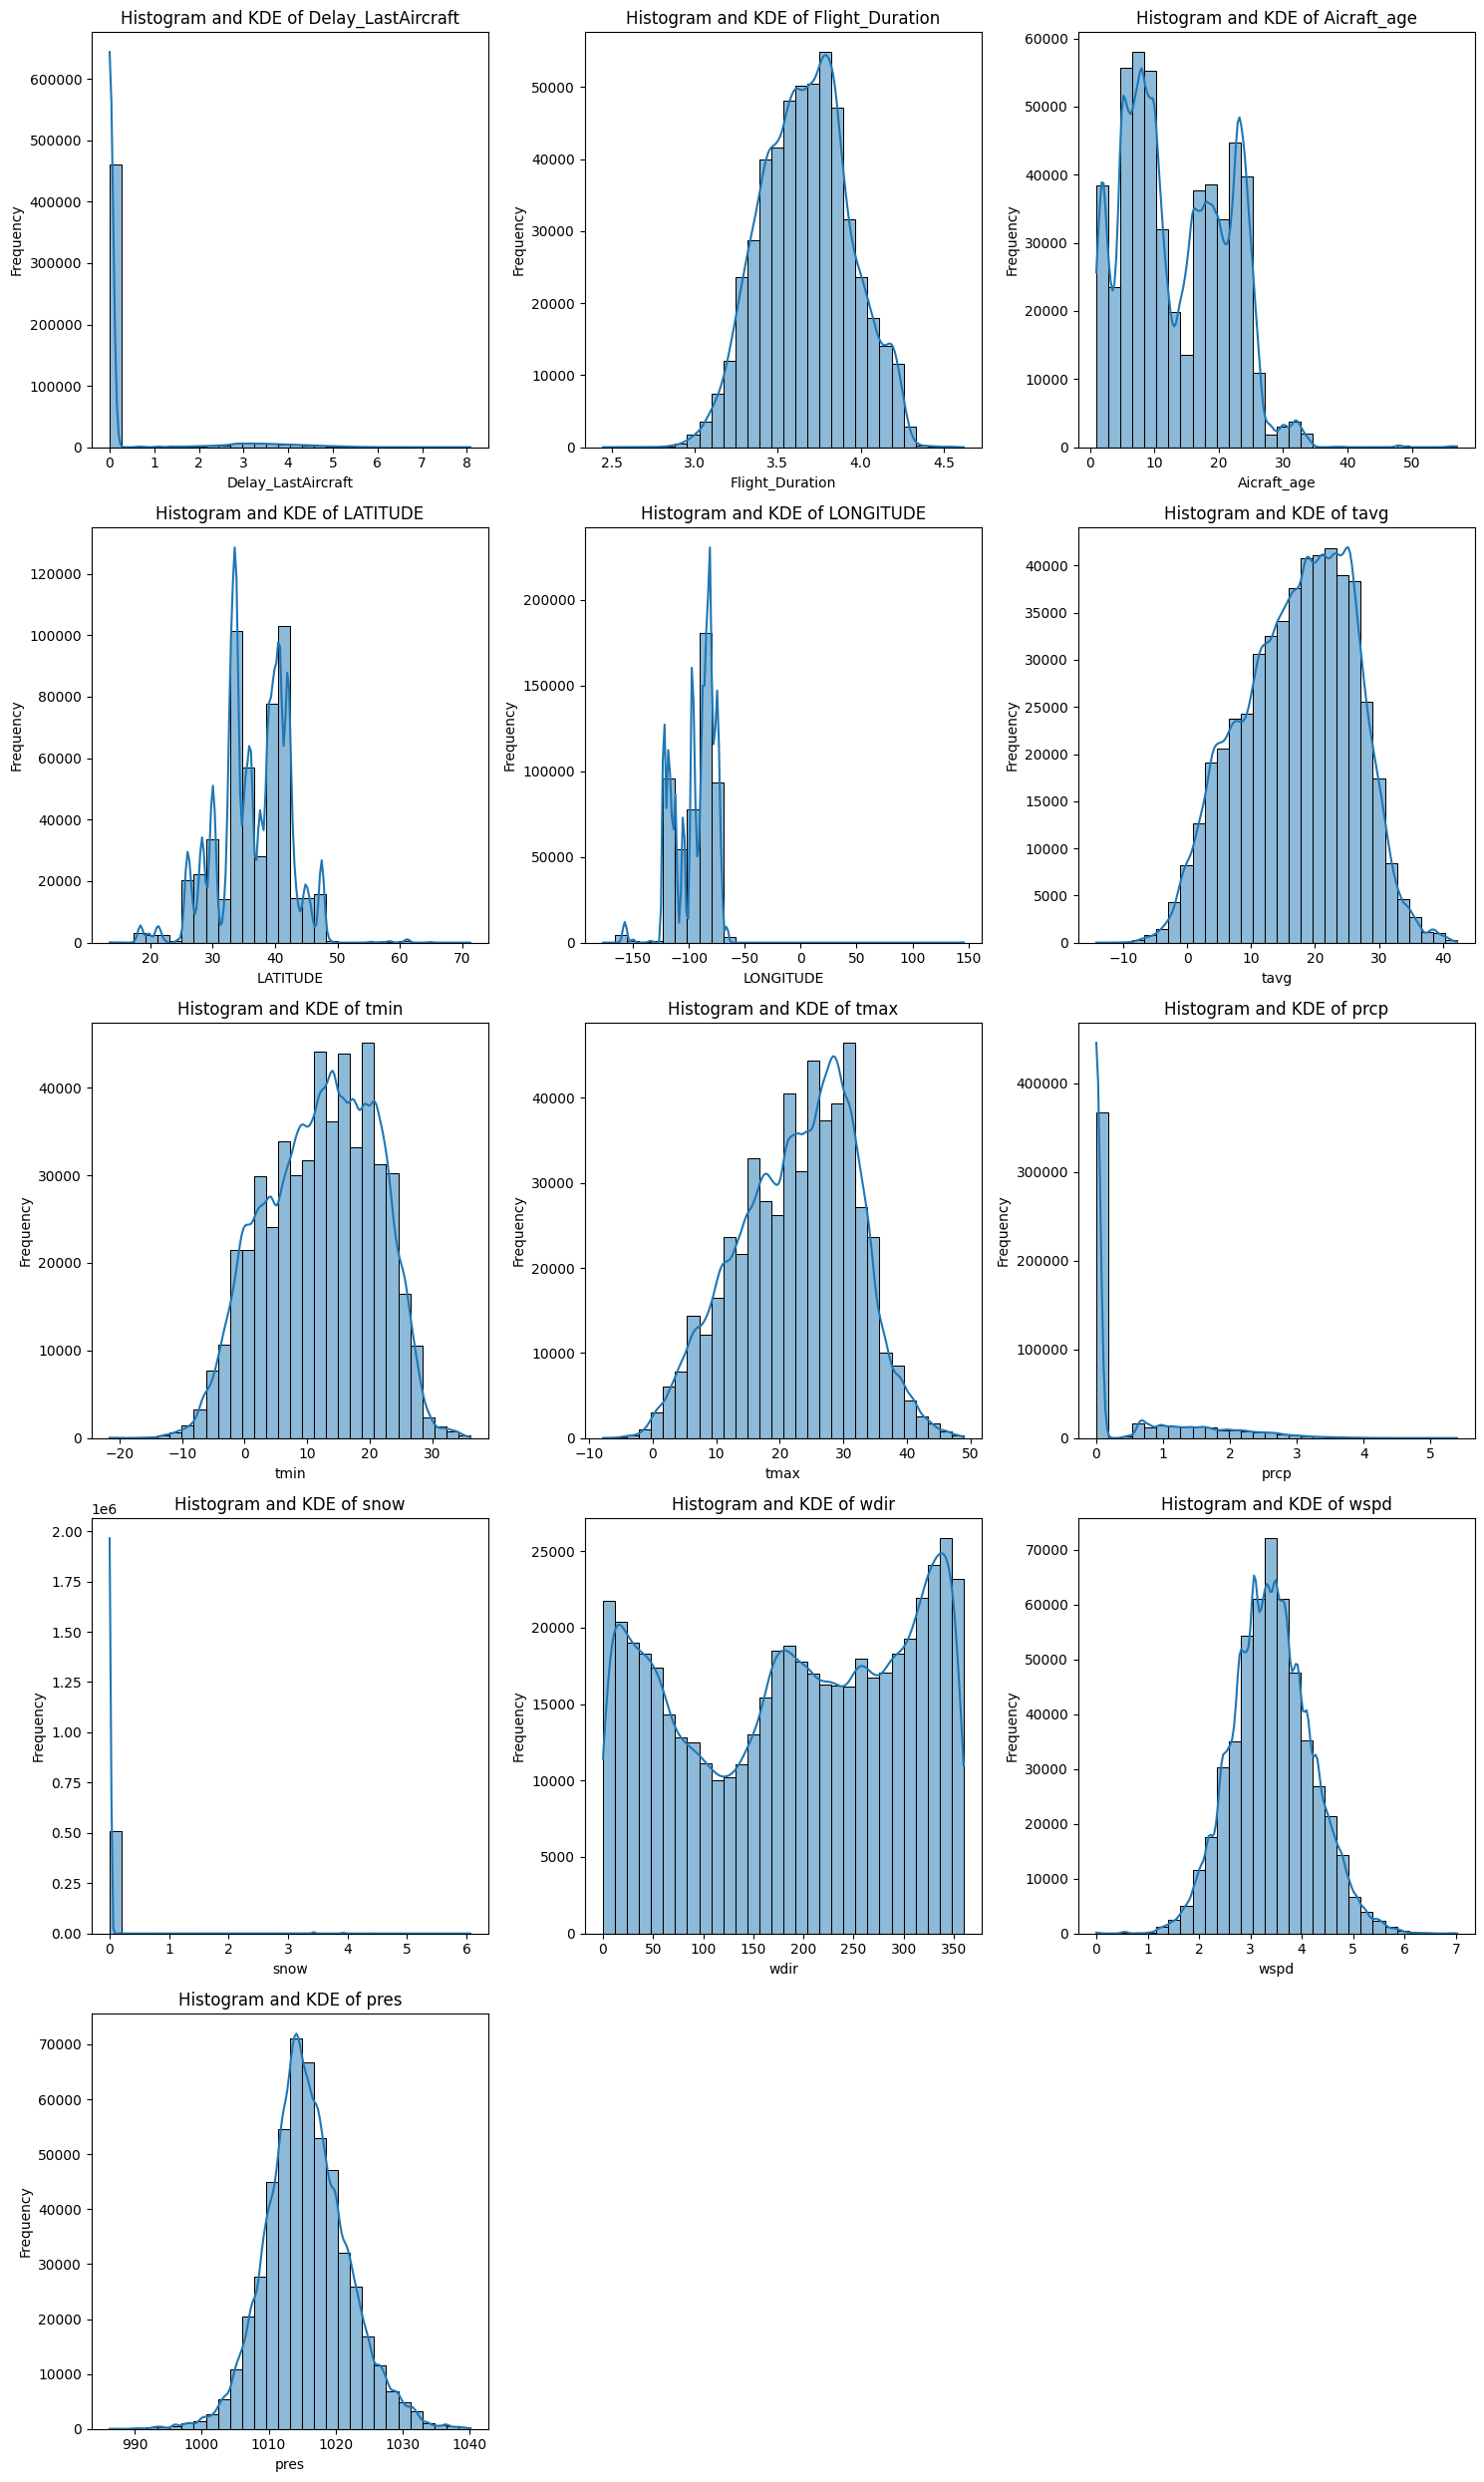

In [35]:
plot_histograms(train_encoded, features_hist)

Randomly reducing the train_set to 25% size for computational performance during the following modeling process.

In [ ]:
# Random subsampling: reduces the training set size to 25%
from sklearn.utils import resample

train_set_subsampled = resample(train_encoded, replace=False, n_samples=int(len(train_set) * 0.25), random_state=42)

print("Original train_set size:", len(train_set))
print("Train_set size after subsampling:", len(train_set_subsampled))

Original train_set size: 539411
Train_set size after subsampling: 134852


In [37]:
train_set_subsampled.sample(2)

,Delay_LastAircraft,Day_Of_Week,Flight_Duration,Aicraft_age,LATITUDE,LONGITUDE,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,Month,Day,Dep_Delay_Tag,Airline_te,Tail_Number_te,Dep_Airport_te,DepTime_label_te,Arr_Airport_te,Distance_type_te,Manufacturer_te,Model_te
3745673,2.772589,7,3.545593,14,41.72400,-71.42822,21.3,18.3,26.1,1.827160,0.0,186.0,3.701351,1013.1,7,2,1,0.245994,0.317722,0.343617,0.425231,0.282226,0.365081,0.240634,0.240634
96337,0.000000,2,3.781153,6,33.94254,-118.40807,15.2,12.2,16.7,2.545822,0.0,216.0,4.404543,1017.6,1,10,0,0.353585,0.324519,0.363073,0.424054,0.369134,0.365439,0.424051,0.432789


In [38]:
# Dividing X and y, train and test
X_train_encoded = train_set_subsampled[features_num + encoded_columns].copy()
X_test_encoded = test_encoded[features_num + encoded_columns].copy()
y_train = train_set_subsampled[target_class]
y_test = test_encoded[target_class]

#Resetting the index of all DataFrames to prevent misalignment
X_train_encoded = X_train_encoded.reset_index(drop=True)
X_test_encoded = X_test_encoded.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


print("X_train_encoded:", X_train_encoded.shape)
print("y_train:", y_train.shape)

print("\nX_test_encoded:", X_test_encoded.shape)
print("y_test:",y_test.shape)

X_train_encoded: (134852, 24)
y_train: (134852,)

X_test_encoded: (128027, 24)
y_test: (128027,)


#### StandartScaling

The standardization of the DataFrame will be used for statistical tests and feature selection, as well as for scale-sensitive analyses.

In [39]:
X_train_scaled, X_test_scaled = scale_features(X_train_encoded, X_test_encoded)

In [40]:
X_train_scaled.sample()

,Delay_LastAircraft,Day_Of_Week,Flight_Duration,Aicraft_age,LATITUDE,LONGITUDE,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,Month,Day,Airline_te,Tail_Number_te,Dep_Airport_te,DepTime_label_te,Arr_Airport_te,Distance_type_te,Manufacturer_te,Model_te
5683,-0.318467,0.007449,0.204437,1.3538,0.591627,1.085249,-1.4352,-1.285049,-1.566913,-0.548089,-0.07944,-1.72055,-0.178084,2.376169,1.579554,0.606054,-0.013469,0.110798,-0.563718,1.19352,0.810748,-0.37376,0.386448,-0.3657


### Feature Selection with ANOVA e FSTS

Selection of variables with high statistical significance in relation to the target (p-value < 0.01)

In [41]:
# ANOVA

from sklearn.feature_selection import f_classif

# Perform ANOVA on training data
f_scores, p_values = f_classif(X_train_scaled, y_train)

# Store results in a DataFrame
anova_results = pd.DataFrame({"Feature": X_train_scaled.columns, "F-Score": f_scores, "p-value": p_values})

# Select features with p-value < 0.05
selected_features_anova = anova_results[anova_results["p-value"] < 0.01]["Feature"].tolist()

print("Selected Features after ANOVA:", selected_features_anova)

Selected Features after ANOVA: ['Delay_LastAircraft', 'Day_Of_Week', 'Flight_Duration', 'Aicraft_age', 'LATITUDE', 'LONGITUDE', 'tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres', 'Month', 'Day', 'Airline_te', 'Tail_Number_te', 'Dep_Airport_te', 'DepTime_label_te', 'Arr_Airport_te', 'Distance_type_te', 'Manufacturer_te', 'Model_te']


Exclude highly correlated and redundant columns (corr > 0.7). 

To select which of the correlated columns will be kept, a correlation analysis with respect to the target will be performed to retain the variable most related to class 1.

In [42]:
# FSTS

# Compute the correlation matrix using ANOVA-selected features
corr_matrix = X_train_scaled[selected_features_anova].corr().abs()

# Calculate the correlation of each feature with the target variable
correlation_with_target = X_train_scaled[selected_features_anova].corrwith(y_train).abs()

# Initialize a list to store features to drop
to_drop = []

# Iterate through the correlation matrix to identify highly correlated features
upper = np.triu(corr_matrix, k=1)  # Upper triangle of the correlation matrix

for column in corr_matrix.columns:
    # Check if any other feature is highly correlated with the current column
    correlated_columns = corr_matrix.columns[upper[:, corr_matrix.columns.get_loc(column)] > 0.7]
    
    for correlated_column in correlated_columns:
        # Compare correlation with the target variable (y_train)
        if correlation_with_target[column] >= correlation_with_target[correlated_column]:
            # Drop the correlated column if the current column is more correlated with the target
            to_drop.append(correlated_column)
        else:
            # Otherwise, drop the current column
            to_drop.append(column)

# Remove duplicates from the list of features to drop
to_drop = list(set(to_drop))

# Print the features that are being dropped due to high correlation with each other
print("Features to be dropped due to high correlation:", to_drop)

# Final feature selection after FSTS, keeping the variables that are not dropped
selected_features_fsts = [f for f in selected_features_anova if f not in to_drop]

print("Selected Features after FSTS:", selected_features_fsts)


Features to be dropped due to high correlation: ['tavg', 'tmax', 'Tail_Number_te', 'Model_te', 'Manufacturer_te']
Selected Features after FSTS: ['Delay_LastAircraft', 'Day_Of_Week', 'Flight_Duration', 'Aicraft_age', 'LATITUDE', 'LONGITUDE', 'tmin', 'prcp', 'wspd', 'pres', 'Month', 'Day', 'Airline_te', 'Dep_Airport_te', 'DepTime_label_te', 'Arr_Airport_te', 'Distance_type_te']


In [43]:
# Applying selected features by ANOVA + FSTS in both scaled and not scaled Dataframes

X_train_selected = X_train_scaled[selected_features_fsts].copy()
X_test_selected = X_test_scaled[selected_features_fsts].copy()

X_train_encoded = X_train_encoded[selected_features_fsts].copy()
X_test_encoded = X_test_encoded[selected_features_fsts].copy()

| DataFrame |    Content   |
| --------- | ----------- |
| X_train_selected |  Scaled X_train with selected features   |
| X_test_selected |   Scaled X_test with selected features  |
|            |            |
| X_train_encoded |   Non-scaled X_train with the selected features    |
| X_test_encoded |    Non-scaled X_test with the selected features   |

### Clustering

The article below proposes a methodology using density-based clusters (DBSCAN) to subdivide the entire dataset into different data groups. After that, each group is trained with a specific machine-learning model for Delay prediction. However, in this study, there was no improvement in predictions when considering different groups via clustering with HDBSCAN, which also required significant computational capacity to form the clusters. Therefore, this approach was not followed, but it is referenced in the study as an interesting method that may be useful for other datasets with different data.

https://www.nature.com/articles/s41598-024-55217-z

----------------------------------------

## Modeling

Generating a classification report for a random classifier, i.e., one that follows only the probabilities according to the natural imbalance of the target. The models will be evaluated based on how they outperform a random classifier.

In [44]:
from sklearn.metrics import classification_report

# Conta a proporção real das classes no conjunto de treinamento
unique, counts = np.unique(y_train, return_counts=True)
class_proportions = counts / counts.sum()

# Gera previsões aleatórias seguindo a proporção das classes
y_pred_random = np.random.choice(unique, size=len(y_test), p=class_proportions)

# Avalia o desempenho do classificador aleatório
print("Random Classifier - Classification Report:")
print(classification_report(y_test, y_pred_random))

Random Classifier - Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.62      0.62     80183
           1       0.37      0.38      0.37     47844

    accuracy                           0.53    128027
   macro avg       0.50      0.50      0.50    128027
weighted avg       0.53      0.53      0.53    128027



### Models with standarized data

Performing a random undersampling to balance classes 0 and 1.

In [45]:
# RandomUndersampling of scaled dataframe
from imblearn.under_sampling import RandomUnderSampler

# Initialize the RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Perform random undersampling on the training set
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train_selected, y_train)

# Print the shapes before and after
print(f"X_train_selected shape: {X_train_selected.shape}")
print(f"X_train_resampled shape: {X_train_undersampled.shape}")


X_train_selected shape: (134852, 17)
X_train_resampled shape: (100678, 17)


#### LogisticRegression

In [46]:
from sklearn.linear_model import LogisticRegression

rl_model = LogisticRegression(random_state=42)
rl_model.fit(X_train_undersampled, y_train_undersampled)

y_train_pred_prueba = rl_model.predict(X_train_undersampled)
print(classification_report(y_train_undersampled, y_train_pred_prueba))

# Previsões no conjunto de teste
y_test_pred_prueba = rl_model.predict(X_test_selected)
print(classification_report(y_test, y_test_pred_prueba))
print("-" * 60)



              precision    recall  f1-score   support

           0       0.65      0.79      0.71     50339
           1       0.73      0.57      0.64     50339

    accuracy                           0.68    100678
   macro avg       0.69      0.68      0.68    100678
weighted avg       0.69      0.68      0.68    100678

              precision    recall  f1-score   support

           0       0.76      0.80      0.78     80183
           1       0.62      0.57      0.60     47844

    accuracy                           0.71    128027
   macro avg       0.69      0.68      0.69    128027
weighted avg       0.71      0.71      0.71    128027

------------------------------------------------------------


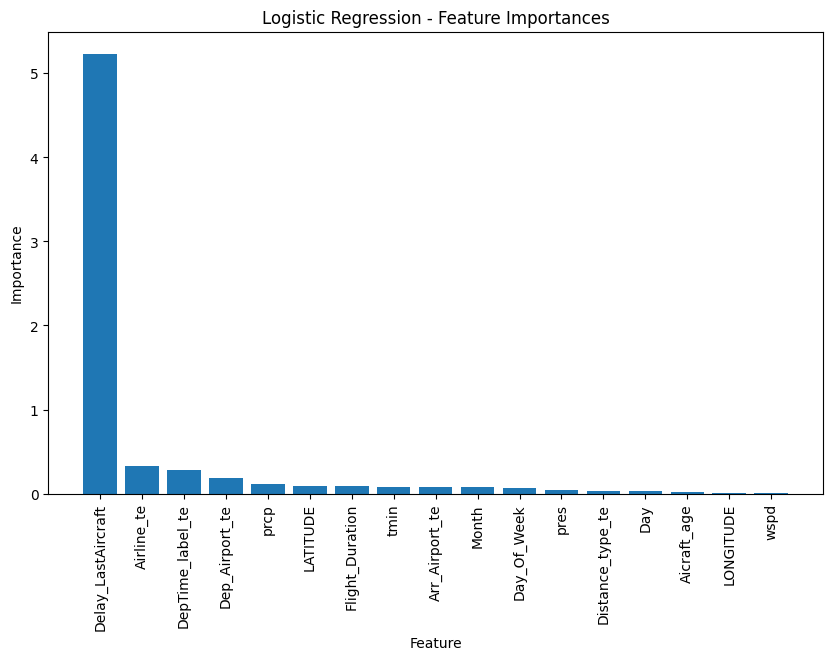

In [47]:
plot_feature_importance_logistic(rl_model, X_train_undersampled.columns, "Logistic Regression")


### Models with non-standarized data (Bagging and Boosting models)

In [48]:
# RandomUndersampling of non-scaled dataframe

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Perform random undersampling on the training set
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_encoded, y_train)

# Print the shapes before and after
print(f"X_train_selected shape: {X_train_encoded.shape}")
print(f"X_train_resampled shape: {X_train_resampled.shape}")

X_train_selected shape: (134852, 17)
X_train_resampled shape: (100678, 17)


In [49]:
# Training and evaluating models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "GradientBoost": GradientBoostingClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, verbose=-1)
}

Generating a loop to print the training and testing classification report for all the models to be tested above.

In [50]:
# Training and evaluating models
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train_resampled, y_train_resampled)
    
    y_train_pred = model.predict(X_train_resampled)
    y_test_pred = model.predict(X_test_encoded)
    
    print(f"\n{model_name} - Training Classification Report:\n{classification_report(y_train_resampled, y_train_pred)}")
    print(f"\n{model_name} - Test Classification Report:\n{classification_report(y_test, y_test_pred)}")


Training RandomForest...

RandomForest - Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50339
           1       1.00      1.00      1.00     50339

    accuracy                           1.00    100678
   macro avg       1.00      1.00      1.00    100678
weighted avg       1.00      1.00      1.00    100678


RandomForest - Test Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77     80183
           1       0.62      0.59      0.60     47844

    accuracy                           0.71    128027
   macro avg       0.69      0.69      0.69    128027
weighted avg       0.71      0.71      0.71    128027


Training XGBoost...

XGBoost - Training Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.85      0.78     50339
           1       0.81      0.66      0.73     50339



### Hyperparameter search with RandomizedSearchCV

F1-score was used as the metric for this problem because both False Positives and False Negatives are harmful. Just as it is very detrimental for a flight that will be delayed to go unrecognized, classifying a flight that is on time as delayed generates false alarms, diverts attention from those that truly matter, and can cause unnecessary stress. Therefore, in this simulation, both classes 0 (on time) and 1 (delayed) will be considered equally important, something that can be adjusted according to the specific business problem, for example, prioritizing the recall of class 1.

In [51]:
from sklearn.model_selection import RandomizedSearchCV

In [52]:
################
# RandomForest #
################

rf_params = {
    'n_estimators': np.arange(100, 500, 100),
    'max_depth': [5, 7, 10, 12, 15],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)
rf_search = RandomizedSearchCV(rf, rf_params, scoring='f1', n_iter=20, cv=5, verbose=1, random_state=42, n_jobs=-1)
rf_search.fit(X_train_resampled, y_train_resampled)
best_random_rf = rf_search.best_estimator_
print("\nRandomForest - Best Estimator:\n", rf_search.best_params_)
print("\nRandomForest - Best Model Classification Report (Train):\n", classification_report(y_train_resampled, best_random_rf.predict(X_train_resampled)))
print("\nRandomForest - Best Model Classification Report (Test):\n", classification_report(y_test, best_random_rf.predict(X_test_encoded)))


Fitting 5 folds for each of 20 candidates, totalling 100 fits

RandomForest - Best Estimator:
 {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 15, 'bootstrap': False}

RandomForest - Best Model Classification Report (Train):
               precision    recall  f1-score   support

           0       0.80      0.94      0.87     50339
           1       0.93      0.77      0.84     50339

    accuracy                           0.85    100678
   macro avg       0.87      0.85      0.85    100678
weighted avg       0.87      0.85      0.85    100678


RandomForest - Best Model Classification Report (Test):
               precision    recall  f1-score   support

           0       0.76      0.81      0.79     80183
           1       0.64      0.58      0.61     47844

    accuracy                           0.72    128027
   macro avg       0.70      0.69      0.70    128027
weighted avg       0.72      0.72      0.72    128027



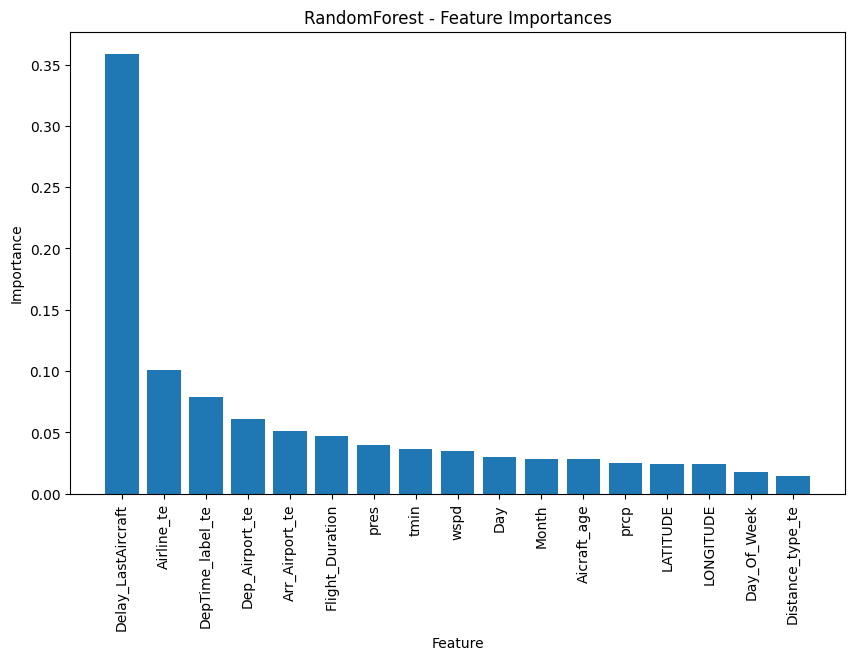

In [53]:
# Feature Importance for RandomForest
plot_feature_importance(best_random_rf, X_train_resampled.columns, "RandomForest")

In [54]:
y_pred_proba_rf = best_random_rf.predict_proba(X_test_encoded)[:, 1]
high_confidence_rf = y_pred_proba_rf > 0.9

y_pred_rf = best_random_rf.predict(X_test_encoded)
true_positives_rf = ((y_pred_rf == 1) & (y_test == 1) & high_confidence_rf).sum()
total_high_confidence_rf = high_confidence_rf.sum()

percentage_rf = (true_positives_rf / total_high_confidence_rf) * 100 if total_high_confidence_rf > 0 else 0
print(f"Random Forest - Percentage of True Positives (Class 1) with >90% Confidence: {percentage_rf:.2f}%")


Random Forest - Percentage of True Positives (Class 1) with >90% Confidence: 100.00%


In [55]:
###########
# XGBoost #
###########

xgb_params = {
    'n_estimators': np.arange(50, 450, 50),
    'max_depth': np.arange(3, 15, 2),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
}
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_search = RandomizedSearchCV(xgb, xgb_params, scoring='f1', n_iter=20, cv=5, verbose=1, random_state=42, n_jobs=-1)
xgb_search.fit(X_train_resampled, y_train_resampled)
best_random_xg = xgb_search.best_estimator_
print("\nXGBoost - Best Estimator:\n", xgb_search.best_params_)
print("\nXGBoost - Best Model Classification Report (Train):\n", classification_report(y_train_resampled, best_random_xg.predict(X_train_resampled)))
print("\nXGBoost - Best Model Classification Report (Test):\n", classification_report(y_test, best_random_xg.predict(X_test_encoded)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits

XGBoost - Best Estimator:
 {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.07444444444444444, 'colsample_bytree': 0.9}

XGBoost - Best Model Classification Report (Train):
               precision    recall  f1-score   support

           0       0.73      0.87      0.79     50339
           1       0.84      0.68      0.75     50339

    accuracy                           0.77    100678
   macro avg       0.78      0.77      0.77    100678
weighted avg       0.78      0.77      0.77    100678


XGBoost - Best Model Classification Report (Test):
               precision    recall  f1-score   support

           0       0.77      0.79      0.78     80183
           1       0.63      0.60      0.62     47844

    accuracy                           0.72    128027
   macro avg       0.70      0.70      0.70    128027
weighted avg       0.72      0.72      0.72    128027



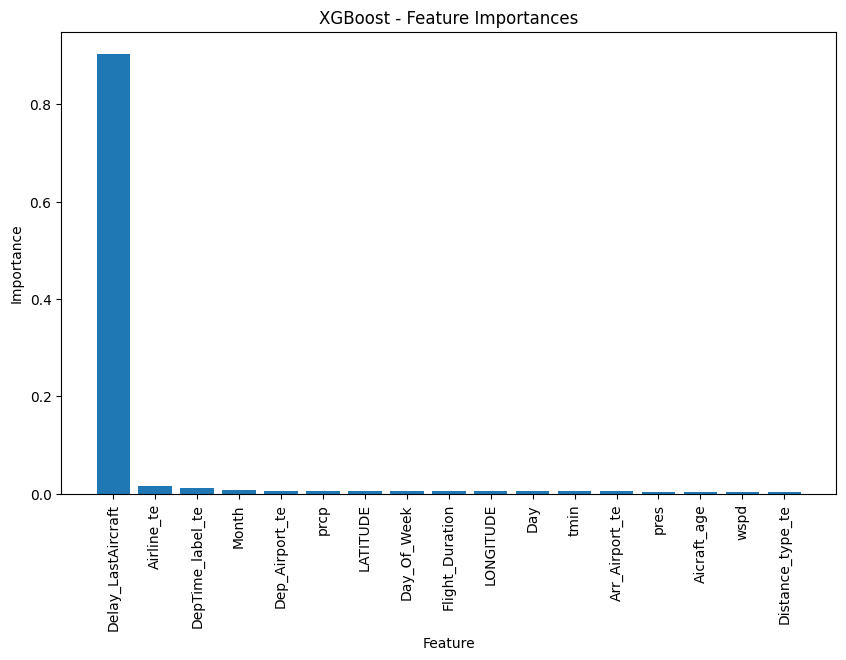

In [56]:
plot_feature_importance(best_random_xg, X_train_resampled.columns, "XGBoost")

In [57]:
y_pred_proba_xg = best_random_xg.predict_proba(X_test_encoded)[:, 1]
high_confidence_xg = y_pred_proba_xg > 0.90

y_pred_xg = best_random_xg.predict(X_test_encoded)
true_positives_xg = ((y_pred_xg == 1) & (y_test == 1) & high_confidence_xg).sum()
total_high_confidence_xg = high_confidence_xg.sum()

percentage_xg = (true_positives_xg / total_high_confidence_xg) * 100 if total_high_confidence_xg > 0 else 0
print(f"XGBoost - Percentage of True Positives (Class 1) with >90% Confidence: {percentage_xg:.2f}%")


XGBoost - Percentage of True Positives (Class 1) with >90% Confidence: 99.77%


In [58]:
############
# LightGBM #
############

import logging
logging.getLogger('lightgbm').setLevel(logging.ERROR)  

lgbm_params = {
    'n_estimators': np.arange(50, 450, 100),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': np.arange(3, 15, 2),
    'num_leaves': np.arange(20, 150, 10),
    'subsample': [0.5, 0.6, 0.7, 0.8]
}
lgbm = LGBMClassifier(random_state=42)
lgbm_search = RandomizedSearchCV(lgbm, lgbm_params, scoring='f1', n_iter=20, cv=5, random_state=42, n_jobs=-1)
lgbm_search.fit(X_train_resampled, y_train_resampled)
best_random_gbm = lgbm_search.best_estimator_
print("\LightGBM - Best Estimator:\n", lgbm_search.best_params_)

print("\nLightGBM - Best Model Classification Report (Train):\n", classification_report(y_train_resampled, best_random_gbm.predict(X_train_resampled)))
print("\nLightGBM - Best Model Classification Report (Test):\n", classification_report(y_test, best_random_gbm.predict(X_test_encoded)))

\LightGBM - Best Estimator:
 {'subsample': 0.7, 'num_leaves': 100, 'n_estimators': 350, 'max_depth': 5, 'learning_rate': 0.1388888888888889}

LightGBM - Best Model Classification Report (Train):
               precision    recall  f1-score   support

           0       0.71      0.84      0.77     50339
           1       0.80      0.65      0.72     50339

    accuracy                           0.75    100678
   macro avg       0.75      0.75      0.74    100678
weighted avg       0.75      0.75      0.74    100678


LightGBM - Best Model Classification Report (Test):
               precision    recall  f1-score   support

           0       0.77      0.79      0.78     80183
           1       0.63      0.60      0.61     47844

    accuracy                           0.72    128027
   macro avg       0.70      0.69      0.70    128027
weighted avg       0.72      0.72      0.72    128027



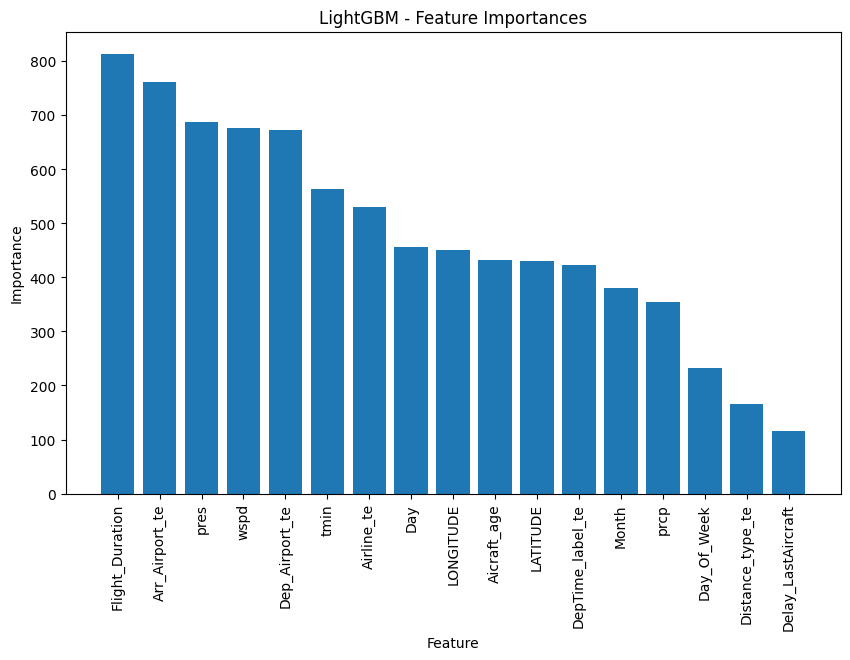

In [59]:
plot_feature_importance(best_random_gbm, X_train_resampled.columns, "LightGBM")

In [60]:
y_pred_proba_gbm = best_random_gbm.predict_proba(X_test_encoded)[:, 1]
high_confidence_gbm = y_pred_proba_gbm > 0.9

y_pred_gbm = best_random_gbm.predict(X_test_encoded)
true_positives_gbm = ((y_pred_gbm == 1) & (y_test == 1) & high_confidence_gbm).sum()
total_high_confidence_gbm = high_confidence_gbm.sum()

percentage_gbm = (true_positives_gbm / total_high_confidence_gbm) * 100 if total_high_confidence_gbm > 0 else 0
print(f"LightGBM - Percentage of True Positives (Class 1) with >90% Confidence: {percentage_gbm:.2f}%")


LightGBM - Percentage of True Positives (Class 1) with >90% Confidence: 99.87%


| Model       | Set  | Accuracy | Macro Recall | Weighted Recall | Macro Precision | Weighted Precision |
|------------|------|----------|--------------|-----------------|-----------------|---------------------|
| RandomForest | Train | 0.85 | 0.85 | 0.85 | 0.87 | 0.87 |
| RandomForest | Test  | 0.72 | 0.69 | 0.72 | 0.70 | 0.72 |
| | | | | | | |
| XGBoost     | Train | 0.77 | 0.77 | 0.77 | 0.78 | 0.78 |
| XGBoost     | Test  | 0.72 | 0.70 | 0.72 | 0.70 | 0.72 |
| | | | | | | |
| LightGBM    | Train | 0.75 | 0.75 | 0.75 | 0.75 | 0.75 |
| LightGBM    | Test  | 0.72 | 0.69 | 0.72 | 0.70 | 0.72 |


### Hyperparameter Optimization for XGBoost Using Hyperopt  

This code optimizes an **XGBoost classifier** using **Hyperopt** to find the best hyperparameters.  

1. **Objective Function**  
   - Trains an XGBoost model with given hyperparameters.  
   - Uses **StratifiedKFold (5 folds)** to ensure balanced class distribution across splits.  
   - Evaluates performance using **F1-score** with `make_scorer()`.  

2. **Hyperparameter Search**  
   - Defines the search space for key hyperparameters (`n_estimators`, `max_depth`, etc.).  
   - Uses **Tree-structured Parzen Estimator (TPE)** to optimize F1-score.  

3. **Model Training & Evaluation**  
   - Trains the best model found on the full training set.  
   - Predicts on both train and test sets.  
   - Outputs **classification reports** for performance analysis.  


In [61]:
best_random_xg.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.07444444444444444, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)>

In [63]:
# Define hyperparameter search space
space = {
    'n_estimators': hp.quniform('n_estimators', 275, 325, 5),
    'max_depth': hp.quniform('max_depth', 5, 10, 0.5),
    'learning_rate': hp.quniform('learning_rate', 0.05, 0.1, 0.001),
    'subsample': hp.choice('subsample', [0.8, 0.85, 0.9, 0.95, 1]),  
    'colsample_bytree': hp.choice('colsample_bytree', [0.8, 0.85, 0.9, 0.95, 1])  
}

In [64]:
from hyperopt import fmin, tpe, hp, Trials
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, make_scorer

def create_model(params):
    return XGBClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        tree_method='gpu_hist',
        gpu_id=0,
        n_jobs=-1
    )

def objective(params):
    model = create_model(params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1 = cross_val_score(model, X_train_resampled, y_train_resampled, cv=skf, scoring=make_scorer(f1_score)).mean()
    return -f1

# Run optimization using Tree-structured Parzen Estimator (TPE)
trials = Trials()
rstate = np.random.default_rng(42)
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)

# Extract best hyperparameters
best_params = {
    'n_estimators': int(best['n_estimators']),
    'max_depth': int(best['max_depth']),
    'learning_rate': best['learning_rate'],
    'subsample': [0.8, 0.85, 0.9, 0.95, 1][best['subsample']],
    'colsample_bytree': [0.8, 0.85, 0.9, 0.95, 1][best['colsample_bytree']]
}

print("\nBest Hyperparameters found by Hyperopt:")
print(best_params)

# Train the best model
best_model_xgb = create_model(best_params)
best_model_xgb.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_train_best = best_model_xgb.predict(X_train_resampled)
y_pred_test_best = best_model_xgb.predict(X_test_encoded)

# Print classification reports
print("\nBest Model Classification Report (Train):\n", classification_report(y_train_resampled, y_pred_train_best))
print("\nBest Model Classification Report (Test):\n", classification_report(y_test, y_pred_test_best))


100%|██████████| 50/50 [05:48<00:00,  6.96s/trial, best loss: -0.6617531150972557]

Best Hyperparameters found by Hyperopt:
{'n_estimators': 280, 'max_depth': 7, 'learning_rate': 0.099, 'subsample': 0.9, 'colsample_bytree': 0.85}

Best Model Classification Report (Train):
               precision    recall  f1-score   support

           0       0.75      0.88      0.81     50339
           1       0.85      0.70      0.77     50339

    accuracy                           0.79    100678
   macro avg       0.80      0.79      0.79    100678
weighted avg       0.80      0.79      0.79    100678


Best Model Classification Report (Test):
               precision    recall  f1-score   support

           0       0.77      0.78      0.77     80183
           1       0.62      0.61      0.61     47844

    accuracy                           0.72    128027
   macro avg       0.70      0.69      0.69    128027
weighted avg       0.71      0.72      0.72    128027



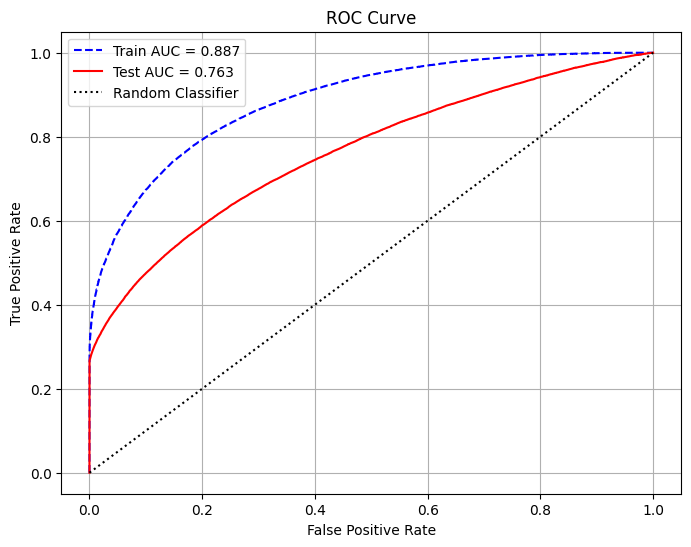

In [65]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
y_prob_train = best_model_xgb.predict_proba(X_train_resampled)[:, 1]
y_prob_test = best_model_xgb.predict_proba(X_test_encoded)[:, 1]

# Compute ROC curve and AUC for training set
fpr_train, tpr_train, _ = roc_curve(y_train_resampled, y_prob_train)
roc_auc_train = auc(fpr_train, tpr_train)

# Compute ROC curve and AUC for test set
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train AUC = {roc_auc_train:.3f}', linestyle='--', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {roc_auc_test:.3f}', linestyle='-', color='red')
plt.plot([0, 1], [0, 1], linestyle='dotted', color='black', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Conclusão do trabalho